In [1]:
import torch
import glob
from datasets import load_dataset, concatenate_datasets


device = torch.device("cuda:0")
resolution = 100

human_dataset = load_dataset("jlbaker361/flickr_humans_5k", split="train")
monkey_dataset = load_dataset("yashikota/imagenet-monkey", split="train")

# new_column_human = ["Human"] * len(human_dataset)
# human_dataset = human_dataset.add_column("input", new_column_human)


# new_column_monkey = ["Human"] * len(monkey_dataset)
# monkey_dataset = monkey_dataset.add_column("input", new_column_monkey)


In [2]:
import torch.nn as nn
import random
from torch.nn import functional as F

class vae(nn.Module):
    def __init__(self, in_channels):
        super(vae, self).__init__()

        self.hidden_dim = resolution ** 2 * in_channels 
        self.latent_dim = 1024

        self.input_dim = resolution ** 2 * in_channels

        self.flatten = nn.Sequential(
            nn.Flatten()
        )
        self.norm1d_block = nn.Sequential(
            nn.BatchNorm1d(self.input_dim)
        )

        self.encode_block1 = nn.Sequential(
            
            nn.Linear(self.input_dim, self.hidden_dim // 2),
            nn.LeakyReLU(0.2),

            nn.Linear(self.hidden_dim // 2, self.hidden_dim // 4),
            nn.LeakyReLU(0.2)
        )
        self.encode_block2 = nn.Sequential(
            nn.Linear(self.hidden_dim // 4, self.hidden_dim // 8),
            nn.LeakyReLU(0.2),

            nn.Linear(self.hidden_dim // 8, self.latent_dim),
            nn.LeakyReLU(0.2)
        )

        self.decode_block1 = nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim // 8),
            nn.LeakyReLU(0.2),

            nn.Linear(self.hidden_dim // 8, self.hidden_dim // 4),
            nn.LeakyReLU(0.2)
        )
        self.decode_block2 = nn.Sequential(
            
            nn.Linear(self.hidden_dim // 4, self.hidden_dim // 2),
            nn.LeakyReLU(0.2),

            nn.Linear(self.hidden_dim // 2, self.input_dim),
            nn.LeakyReLU(0.2)
        )

        self.final_layer = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, label_image, residual_image):
        x = self.flatten(label_image)
        self.residual = self.flatten(residual_image)

        print("residual shape:", self.residual.shape)
        
        output = self.encode_block1(x)
        output = self.encode_block2(output)

        output += self.residual

        output = self.decode_block1(output)
        output = self.decode_block2(output)

        output += self.flatten(label_image)

        output = self.final_layer(output)

        output = self.norm1d_block(output)

        return output
    def gen_test_sample(self, x, norm, L, R):

        self.residual = x
        
        output = self.encode_block1(x)
        output = self.encode_block2(output)

        output += self.residual

        self.latent = output.cpu().detach().numpy()
        
        self.min_elm = self.latent.min()
        self.max_elm = self.latent.max()

        for i in range(len(self.latent)):
            for j in range(L, R, 1):
                self.latent[i][j] += random.uniform(self.min_elm, self.max_elm) / norm

        self.new_output = torch.tensor(output, dtype=torch.float32).to(device)


        self.new_output = self.decode_block1(self.new_output)
        self.new_output = self.decode_block2(self.new_output)

        self.new_output += self.residual

        self.new_output = self.final_layer(self.new_output)


        return self.new_output

In [3]:
import torch.utils
from torchsummary import summary


model = vae(in_channels=1).to(device)

epochs = 10
lr = 0.001
optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

batch_size = 100

In [4]:
from torchvision import transforms

train_transforms = transforms.Compose(
        [
            transforms.Resize((resolution, resolution)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )

residual_transforms = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )

def preprocess_train(examples):
      images = [image.convert("RGB") for image in examples['image']]
      examples["pixel_values"] = [train_transforms(image) for image in images]
      examples["residual_values"] = [residual_transforms(image) for image in images]

      # examples["labels"] = examples["input"]
      # examples["input_ids"] = tokenize_captions(examples)
      return examples

def collate_fn(examples):
      pixel_values = torch.stack([example["pixel_values"] for example in examples])
      pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

      residual_values = torch.stack([example["residual_values"] for example in examples])
      residual_values = residual_values.to(memory_format=torch.contiguous_format).float()

      # inputs = torch.stack([example["labels"] for example in examples])
      # inputs = inputs.to(memory_format=torch.contiguous_format).float()


      # input_ids = torch.stack([example["input_ids"] for example in examples])
      return {"pixel_values": pixel_values, "residual_values": residual_values}

dataset_full = concatenate_datasets([human_dataset, monkey_dataset])

human_half_dataset = human_dataset.select(range(1000)) 

dataset_full = dataset_full.with_transform(preprocess_train)
human_dataset = human_dataset.with_transform(preprocess_train)
monkey_dataset = monkey_dataset.with_transform(preprocess_train)
human_half_dataset = human_half_dataset.with_transform(preprocess_train)


print(dataset_full)
batch_size = 100
train_dataloader = torch.utils.data.DataLoader(
    human_half_dataset,
    collate_fn = collate_fn,
    shuffle=True,
    batch_size=batch_size,
    num_workers=2
)

print(train_dataloader)



Dataset({
    features: ['image', 'split', 'src', 'style', 'label'],
    num_rows: 15400
})


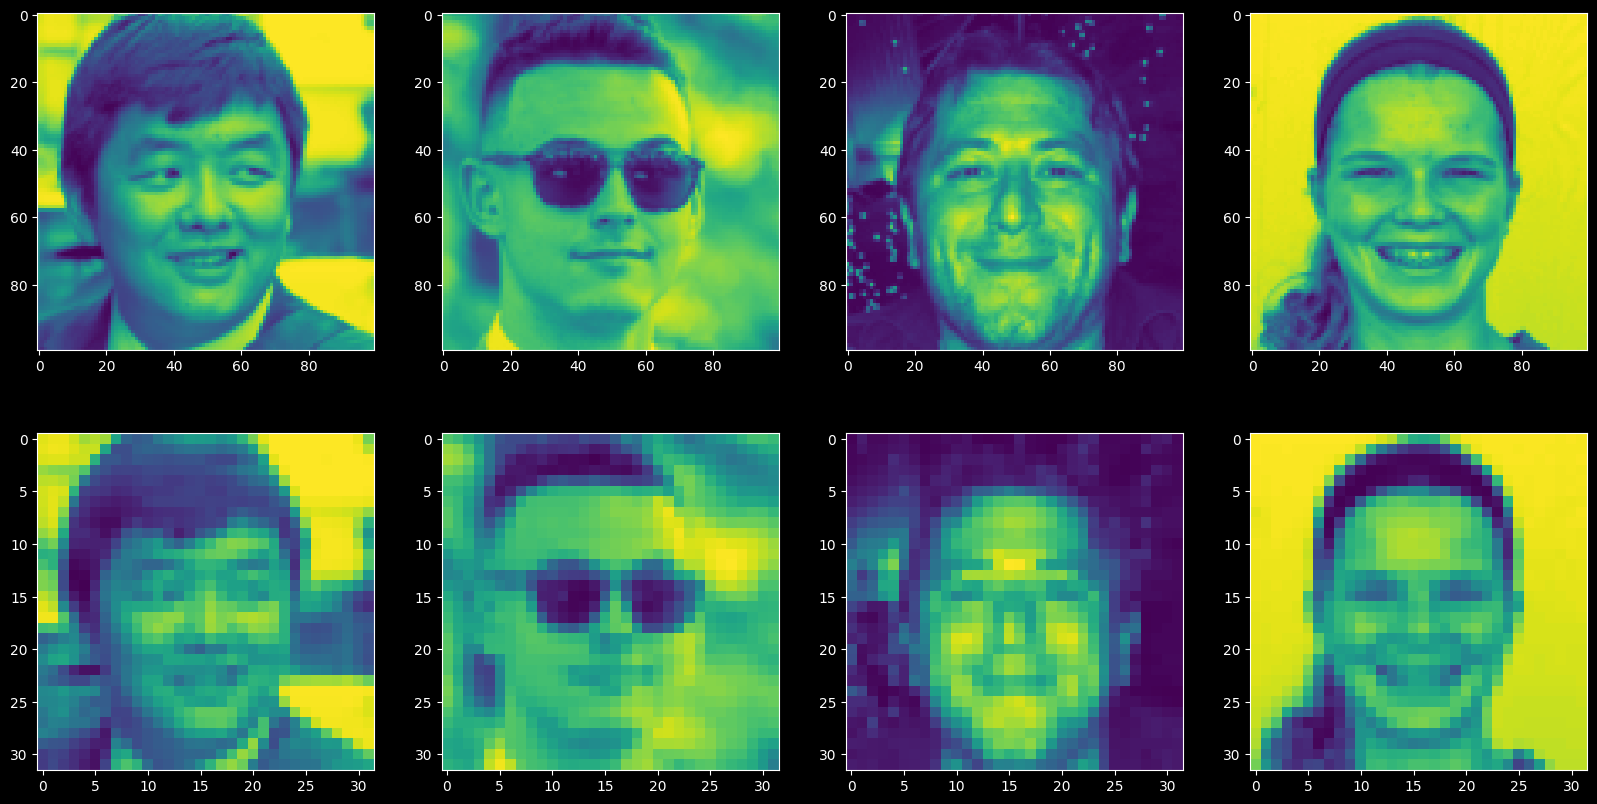

In [5]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

batch = next(iter(train_dataloader))

ax = plt.figure(figsize=(20, 10)).subplots(2, 4)

ax[0, 0].imshow(batch["pixel_values"][0].permute(1, 2, 0))
ax[0, 1].imshow(batch["pixel_values"][1].permute(1, 2, 0))
ax[0, 2].imshow(batch["pixel_values"][2].permute(1, 2, 0))
ax[0, 3].imshow(batch["pixel_values"][3].permute(1, 2, 0))

ax[1, 0].imshow(batch["residual_values"][0].permute(1, 2, 0))
ax[1, 1].imshow(batch["residual_values"][1].permute(1, 2, 0))
ax[1, 2].imshow(batch["residual_values"][2].permute(1, 2, 0))
ax[1, 3].imshow(batch["residual_values"][3].permute(1, 2, 0))




residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])


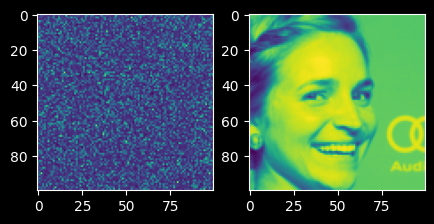

Epoch:  0
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  10.19575834274292
Epoch:  1
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  9.859591662883759
Epoch:  2
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torc

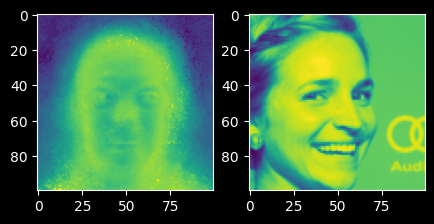

Epoch:  10
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  7.512627601623535
Epoch:  11
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  7.310280025005341
Epoch:  12
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: t

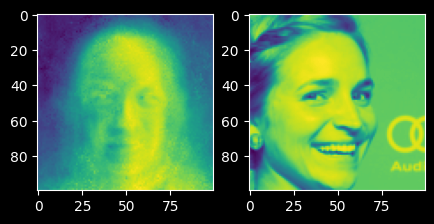

Epoch:  20
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  5.428077280521393
Epoch:  21
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  5.278006494045258
Epoch:  22
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: t

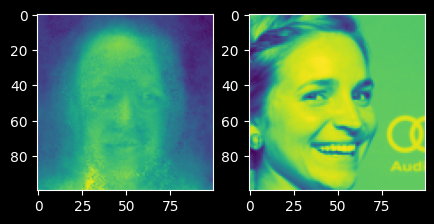

Epoch:  30
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  4.054678320884705
Epoch:  31
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  3.943262130022049
Epoch:  32
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: t

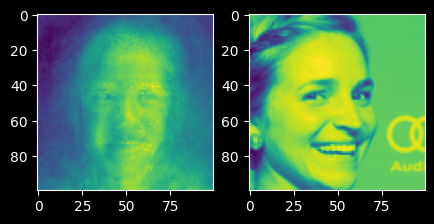

Epoch:  40
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  2.9646556675434113
Epoch:  41
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  2.8298932015895844
Epoch:  42
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape:

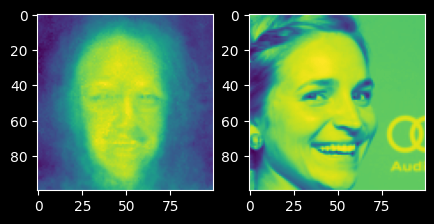

Epoch:  50
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  2.135671302676201
Epoch:  51
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  2.065409690141678
Epoch:  52
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: t

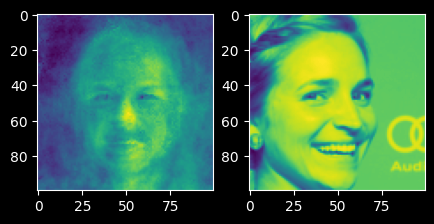

Epoch:  60
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  1.5745842307806015
Epoch:  61
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  1.5261801183223724
Epoch:  62
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape:

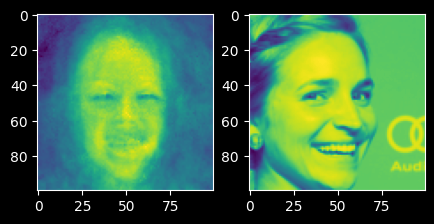

Epoch:  70
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  1.1710618361830711
Epoch:  71
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  1.1350372657179832
Epoch:  72
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape:

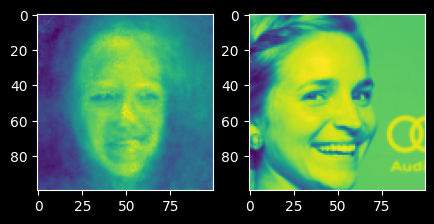

Epoch:  80
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  0.883453443646431
Epoch:  81
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  0.8556702360510826
Epoch:  82
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: 

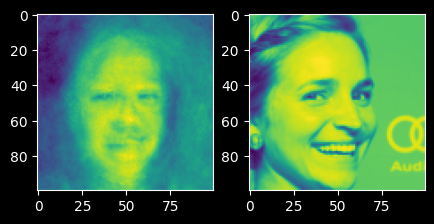

Epoch:  90
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  0.6733362451195717
Epoch:  91
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
--> Loss total:  0.6582638546824455
Epoch:  92
residual shape: torch.Size([100, 1024])
residual shape: torch.Size([100, 1024])
residual shape:

In [7]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

test_batch = batch = next(iter(train_dataloader))

def train(epoch):

    model.train()

    print("Epoch: ", epoch)
    loss_total = 0;

    for batch_idx, batch in (enumerate(train_dataloader)):

        # print(batch["pixel_values"].shape)

        labels = batch["pixel_values"].reshape(-1, 1, resolution, resolution).to(device)
        res_labels = batch["residual_values"].reshape(-1, 1, 32, 32).to(device)

        # print(labels.shape)

        pred = model(labels, res_labels).reshape(-1, 1, resolution, resolution)

        # print(pred.shape)
        # print(labels.shape)
        loss = loss_fn(pred, labels)
        #print("loss: ", loss)
        
        loss_total += loss.item()
        optimizer.zero_grad()


        loss.backward()


        optimizer.step()

            
    print("--> Loss total: ", loss_total)



for i in range(100):

    if(i % 10 == 0):
        model.eval()

        plt.style.use("dark_background")

        batch = test_batch
        # print(batch["pixel_values"].shape)
        labels = batch["pixel_values"].reshape(-1, 1, resolution, resolution).to(device)
        res_labels = batch["residual_values"].reshape(-1, 1, 32, 32).to(device)

        # print(labels.shape)

        pred = model(labels, res_labels).reshape(-1, 1, resolution, resolution)

        # print(batch_to_device.shape)


        pred = model(labels, res_labels)

        # print(pred.shape)


        pred = pred.reshape(-1, 1, resolution, resolution)

        # pred = pred.reshape(-1, resolution, resolution, 3)

        # print(pred.shape)

        image = pred[0].permute(1, 2, 0).cpu().detach().numpy()

    
        ax = plt.figure(figsize=(5, 10)).subplots(1, 2)
        ax[0].imshow(image)
        ax[1].imshow(batch["pixel_values"][0].reshape(resolution, resolution))
        plt.show()
    train(i)


In [8]:
torch.save(model, "./VAE_from_scratch_1k_residual_paths_V1.pth")

residual shape: torch.Size([100, 1024])
torch.Size([100, 10000])
torch.Size([100, 100, 100])


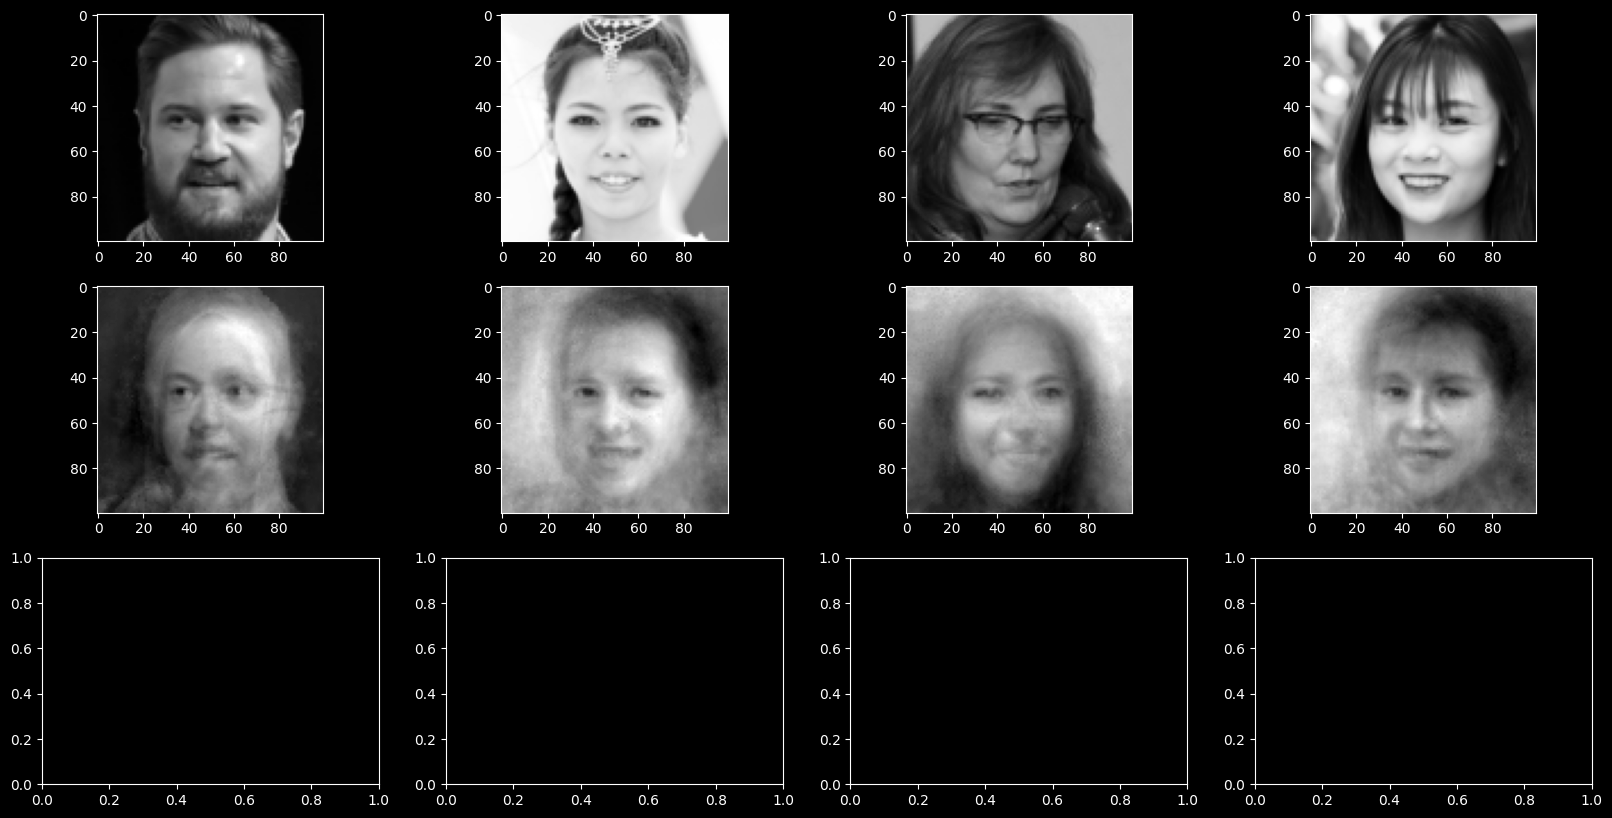

In [12]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

model.eval()

batch = next(iter(train_dataloader))

batch["pixel_values"] = batch["pixel_values"].reshape(-1, resolution, resolution)

ax = plt.figure(figsize=(20, 10)).subplots(3, 4)

ax[0, 0].imshow(batch["pixel_values"][0], cmap="gray")#.permute(1, 2, 0))
ax[0, 1].imshow(batch["pixel_values"][1], cmap="gray")#.permute(1, 2, 0))
ax[0, 2].imshow(batch["pixel_values"][2], cmap="gray")#.permute(1, 2, 0))
ax[0, 3].imshow(batch["pixel_values"][3], cmap="gray")#.permute(1, 2, 0))

batch["pixel_values"] = batch["pixel_values"].reshape(-1, 1, resolution, resolution)
batch["residual_values"] = batch["residual_values"].reshape(-1, 1, 32, 32)


batch_to_device = batch["pixel_values"].to(device)
batch_to_res = batch["residual_values"].to(device)


pred = model(batch_to_device, batch_to_res)


print(pred.shape)

pred = pred.reshape(-1, resolution, resolution)


# pred = pred.reshape(-1, resolution, resolution, 3)

print(pred.shape)

ax[1, 0].imshow(pred[0].cpu().detach().numpy(), cmap="gray")
ax[1, 1].imshow(pred[1].cpu().detach().numpy(), cmap="gray")
ax[1, 2].imshow(pred[2].cpu().detach().numpy(), cmap="gray")
ax[1, 3].imshow(pred[3].cpu().detach().numpy(), cmap="gray")


# ax[2, 0].imshow(pred_noise[0].cpu().detach().numpy(), cmap="gray")
# ax[2, 1].imshow(pred_noise[1].cpu().detach().numpy(), cmap="gray")
# ax[2, 2].imshow(pred_noise[2].cpu().detach().numpy(), cmap="gray")
# ax[2, 3].imshow(pred_noise[3].cpu().detach().numpy(), cmap="gray")

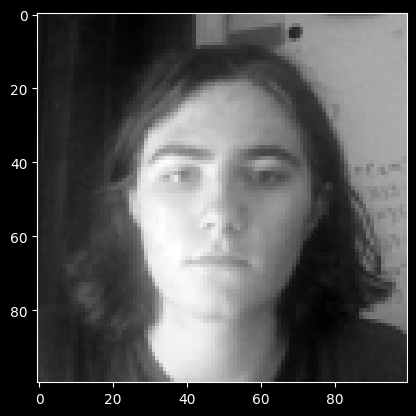

In [ ]:
import PIL.Image
import numpy as np
import PIL.ImageOps 


img = PIL.Image.open("./chuchu2.png").resize((resolution, resolution))

img = PIL.ImageOps.grayscale(img)

plt.imshow(img, cmap="gray")

input_arr = np.array(img)

torch.Size([1, 1, 100, 100])
torch.Size([1, 10000])
torch.Size([1, 100, 100])


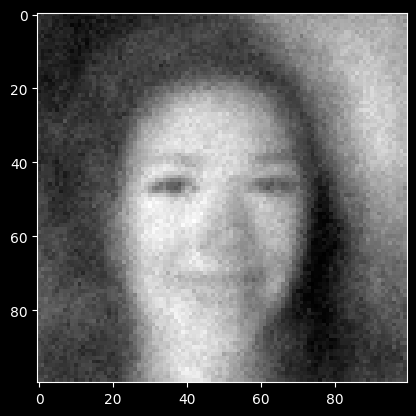

In [ ]:
image_tensor = torch.tensor([input_arr], dtype=torch.float32).reshape(1, 1, resolution, resolution)



batch_to_device = image_tensor.to(device)

print(batch_to_device.shape)

pred = model(batch_to_device)

print(pred.shape)

pred = pred.reshape(-1, resolution, resolution)

# pred = pred.reshape(-1, resolution, resolution, 3)

print(pred.shape)

plt.imshow(pred[0].cpu().detach().numpy(), cmap="gray")
plt.show()